# ImageNet Fine Tuning Exit Flow
This experiment will involve fine-tuning the pretrained Xception model. It will explore retraining the top layer and exit flow of the model.

## Setup

In [1]:
!nvidia-smi

Fri Sep 27 23:51:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B2:00.0 Off |                    0 |
| N/A   30C    P0             40W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-09-27 23:51:31.224609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 23:51:31.240360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 23:51:31.256378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 23:51:31.261142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 23:51:31.273536: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [7]:
import numpy as np
import keras
# import keras_cv
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

In [8]:
!pwd
!ls koa_scratch

/home/jctactay
images


## Data preprocessing

In [9]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict(img_dir):
    imgs = {}
    paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()
home = "/home/jctactay/koa_scratch/images"

imgs = load_images_into_dict(home)
print(f"Done in {time() - t0: .3f}s")

Done in  155.781s


In [10]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [11]:
print(len(imgs))

3613


In [12]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [13]:
labels.quality.value_counts()

quality
2    1479
1    1116
3     991
Name: count, dtype: int64

In [14]:
# check for nans
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [15]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           3  
1           2  
2           1  
3          

In [16]:
Y = labels.quality
# print
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1 2]
3586
3586


In [17]:
print(len(X_train), len(X_val), len(X_test))

2151 717 718


In [18]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[1.07174888 0.80834273 1.20504202]


array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [19]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=42)
])

poor_augmentation_layers = keras.Sequential([
    keras.layers.RandomRotation(factor=0.1, seed=42),
    # keras_cv.layers.RandomSharpness(factor=0.2, value_range=[0,1], seed=42),
    keras.layers.RandomFlip(mode="vertical", seed=42),
    # keras_cv.layers.RandomSaturation(factor=(0.0, 0.5), seed=42)
])

2024-09-27 23:54:14.447860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [20]:
def augment_image(image, label, weight):
    image = augmentation_layers(image)
    if tf.math.reduce_any(tf.equal(label, 2)):
        image = poor_augmentation_layers(image)
    return image, label, weight

In [21]:
t0 = time()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, sample_weights))
# controls augmentation
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print("Done in %0.3fs" % (time() - t0))

Done in 1.998s


## Visualize augmentations

In [22]:
# Inspect the structure of the dataset
for batch in train_dataset.take(1):
    print("Batch structure:")
    for element in batch:
        print(f"Element shape: {element.shape}")
        print(f"Element type: {type(element)}")

Batch structure:
Element shape: (32, 128, 128, 3)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>


2024-09-27 23:54:17.210657: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


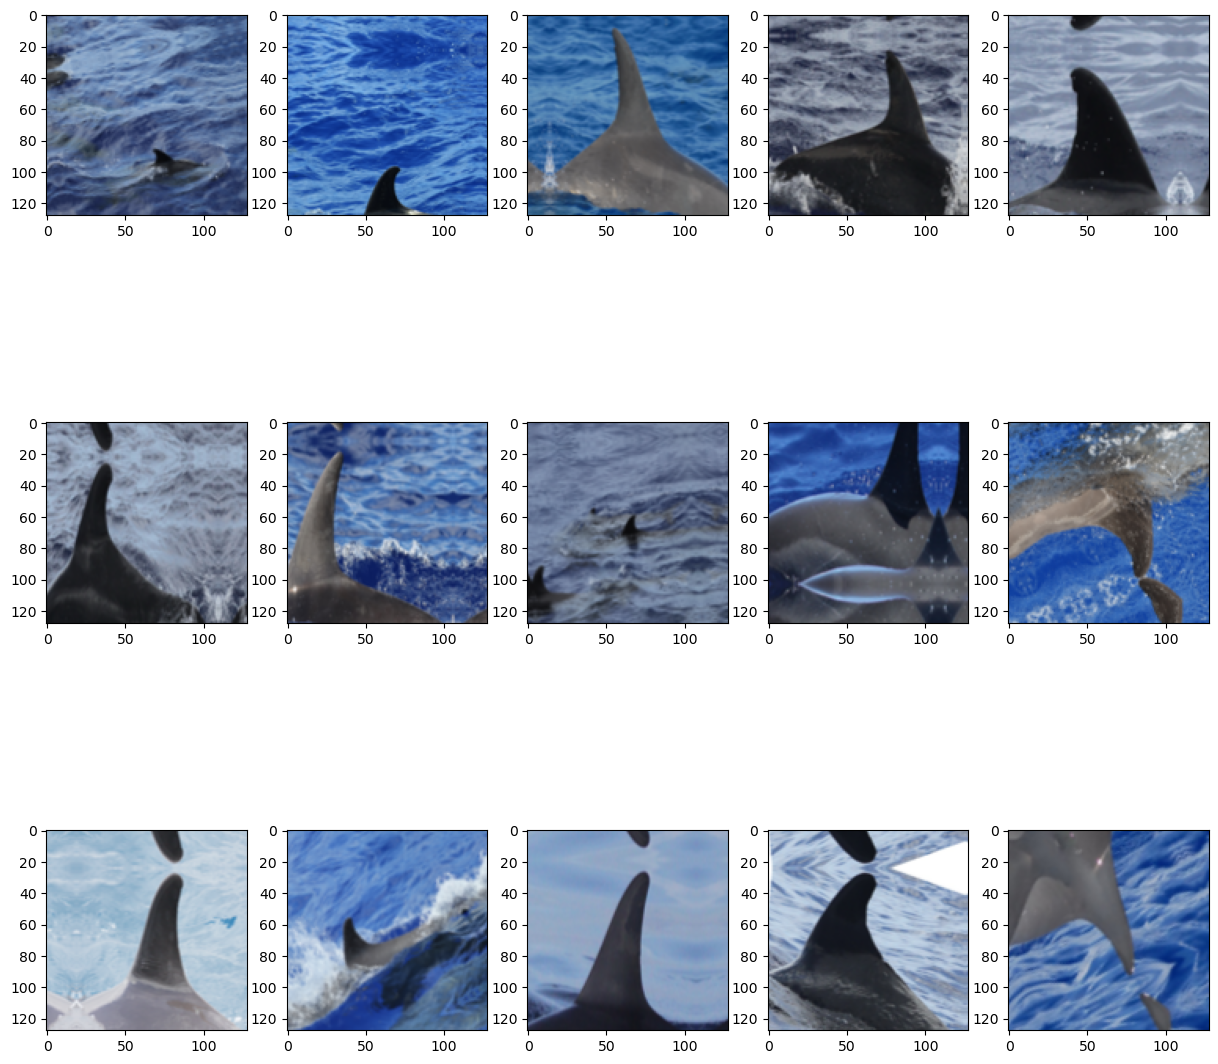

2024-09-27 23:54:18.982860: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
def visualize_batch_augmentation(dataset, num_images=15):
    for batch in dataset.take(1):  # Take one batch
        images, _, _ = batch
        plt.figure(figsize=(15, 15))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 5, i + 1)
            image = images[i].numpy()
            image = (image + 1) / 2
            plt.imshow(image)
        plt.show()

# Visualize augmented images
visualize_batch_augmentation(train_dataset)

## Model

In [24]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

In [25]:
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer_2… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [26]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
# x = augmentation_layers(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,962,731 (87.60 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [27]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [28]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

## Initial fit

In [29]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callback)

Epoch 1/30


I0000 00:00:1727481264.831710   76296 service.cc:146] XLA service 0x145a4400a1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727481264.831748   76296 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-27 23:54:24.996679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 23:54:25.727800: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 5/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3457 - loss: 15.4481

I0000 00:00:1727481269.865239   76296 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.4817 - loss: 10.1062 - val_accuracy: 0.4505 - val_loss: 3.5598
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5929 - loss: 2.6671 - val_accuracy: 0.4784 - val_loss: 2.2343
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5629 - loss: 1.7025 - val_accuracy: 0.4644 - val_loss: 1.7993
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5768 - loss: 1.3063 - val_accuracy: 0.4784 - val_loss: 1.6380
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.5986 - loss: 1.1374 - val_accuracy: 0.4100 - val_loss: 1.5496
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5847 - loss: 1.0177 - val_accuracy: 0.4393 - val_loss: 1.4742
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5778 - loss: 1.0096 - val_accuracy: 0.4979 - val_loss: 1.2264
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5938 - loss: 0.9325 - val_accuracy: 0.4672 - val_los

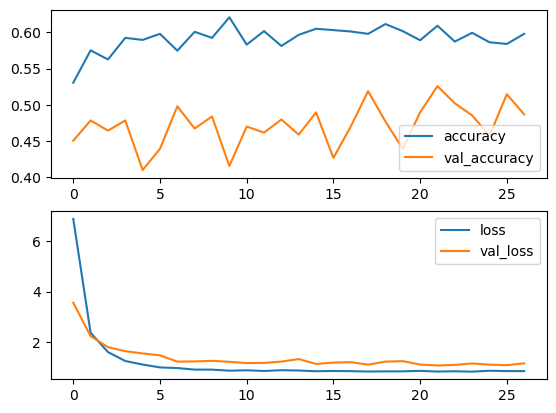

In [30]:
plot_history(history)

In [31]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       224
           1       0.47      0.55      0.51       296
           2       0.60      0.46      0.52       198

    accuracy                           0.51       718
   macro avg       0.53      0.50      0.51       718
weighted avg       0.52      0.51      0.51       718



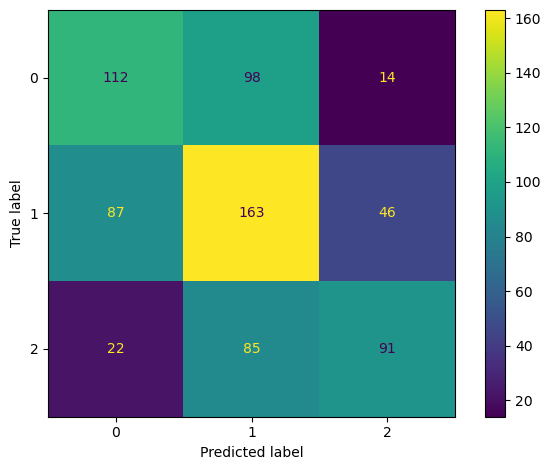

In [32]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Exit flow

### Block 14

In [33]:
print(base_model.layers[-7])
print(base_model.layers[-6])

<Add name=add_11, built=True>
<SeparableConv2D name=block14_sepconv1, built=True>


In [34]:
# unfreeze last exit flow block (6 layers)
for layer in base_model.layers[-6:]:
    layer.trainable = True
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer_2… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [35]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [36]:
# last block unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.5008 - loss: 1.0200 - val_accuracy: 0.4909 - val_loss: 1.2232
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6268 - loss: 0.8089 - val_accuracy: 0.5146 - val_loss: 1.1412
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6393 - loss: 0.7500 - val_accuracy: 0.5202 - val_loss: 1.0972
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6449 - loss: 0.7094 - val_accuracy: 0.5411 - val_loss: 1.0683
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6746 - loss: 0.6746 - val_accuracy: 0.5384 - val_loss: 1.0745
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6819 - loss: 0.6671 - val_accuracy: 0.5411 - val_loss: 1.0331
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6895 - loss: 0.6725 - val_accuracy: 0.5328 - val_loss: 1.0333
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6833 - loss: 0.6543 - val_accuracy: 0.5523

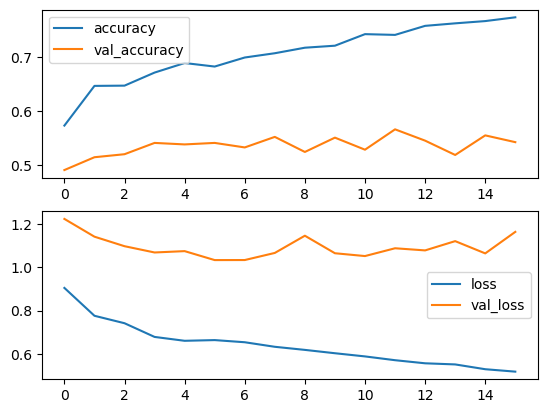

In [37]:
plot_history(history)

In [38]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       224
           1       0.50      0.51      0.51       296
           2       0.68      0.45      0.54       198

    accuracy                           0.55       718
   macro avg       0.58      0.55      0.55       718
weighted avg       0.57      0.55      0.55       718



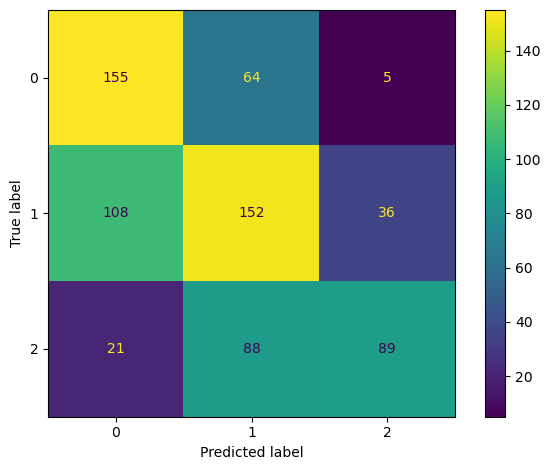

In [39]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

### Block 13

In [40]:
print(base_model.layers[-17])
print(base_model.layers[-16])

<Add name=add_10, built=True>
<Activation name=block13_sepconv1_act, built=True>


In [41]:
# unfreeze entire exit flow block (16 layers)
for layer in base_model.layers[-16:]:
    layer.trainable = True
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer_2… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [42]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [43]:
# exit flow unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.7112 - loss: 0.6524 - val_accuracy: 0.5105 - val_loss: 1.3763
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6952 - loss: 0.6452 - val_accuracy: 0.5202 - val_loss: 1.3824
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.7228 - loss: 0.6203 - val_accuracy: 0.5202 - val_loss: 1.3210
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.7493 - loss: 0.5893 - val_accuracy: 0.5230 - val_loss: 1.3340
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7198 - loss: 0.5986 - val_accuracy: 0.5328 - val_loss: 1.2298
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7327 - loss: 0.5945 - val_accuracy: 0.5230 - val_loss: 1.2489
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.7285 - loss: 0.6031 - val_accuracy: 0.5328 - val_loss: 1.2089
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7368 - loss: 0.5898 - val_accuracy: 0.53

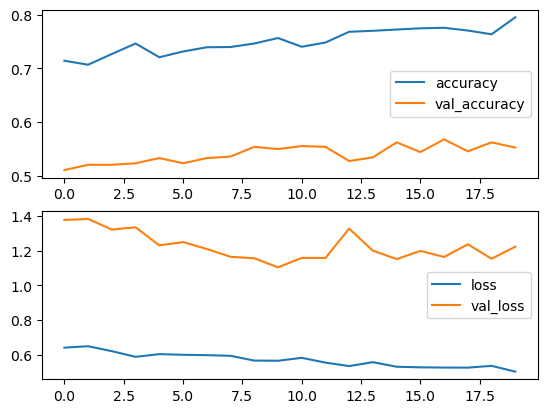

In [44]:
plot_history(history)

In [45]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       224
           1       0.47      0.60      0.53       296
           2       0.75      0.26      0.39       198

    accuracy                           0.54       718
   macro avg       0.60      0.52      0.52       718
weighted avg       0.58      0.54      0.52       718



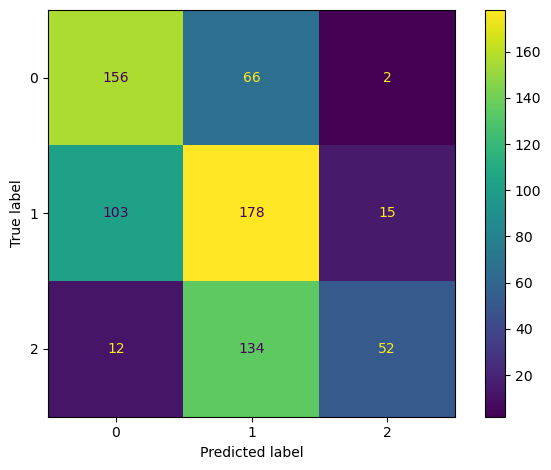

In [46]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Analysis

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
478


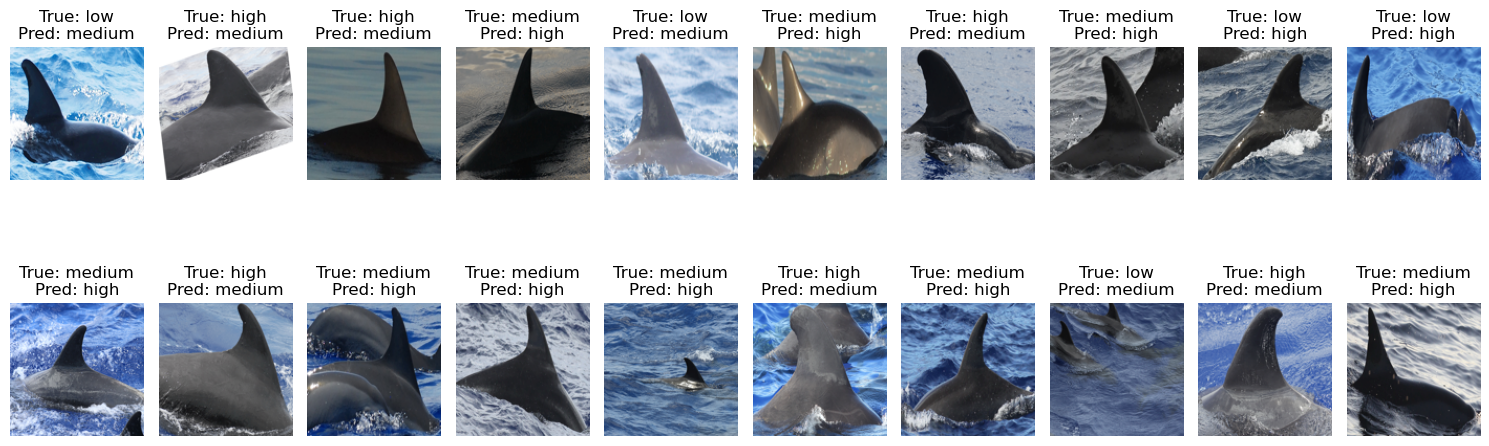

In [68]:
import random
images = []
labels = []
for batch in test_dataset:
    image_batch, label_batch = batch
    images.append((image_batch.numpy() + 1) * 127.5)
    labels.append(label_batch.numpy())
X_test = np.concatenate(images)
y_test = np.concatenate(labels)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = ['high', 'medium', 'low'] 

incorrect_indices = np.where(y_pred != y_test)[0]
print(len(incorrect_indices))

subset_size = 20
n_cols = 10
n_rows = subset_size // n_cols + 1 * (subset_size % n_cols)

subset_indices = random.sample(list(incorrect_indices), min(subset_size, len(incorrect_indices)))

plt.figure(figsize=(15, 6))

for i, incorrect in enumerate(subset_indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(X_test[incorrect].astype('uint8'))  # Assuming images are normalized
    plt.title(f"True: {class_names[y_test[incorrect]]}\nPred: {class_names[y_pred[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

